In [83]:
%load_ext autoreload
%autoreload 2
from CONSTANTS import ALSO_USE_CLINICAL_DATA
ALSO_USE_CLINICAL_DATA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [84]:
USE_FULL_TRAINED = True
FILE_NAME = "full_GENEI" +(ALSO_USE_CLINICAL_DATA*"-WITH-CLINICAL-DATA")+ ".csv" if USE_FULL_TRAINED else "tree_predictions_full.csv"
COLUMN_NAME = 'risk_group' if USE_FULL_TRAINED else 'Tree_group'

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.utils import concordance_index

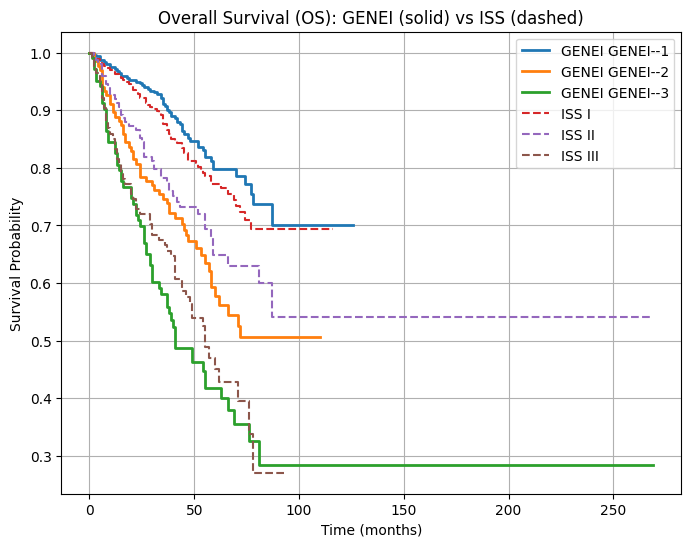

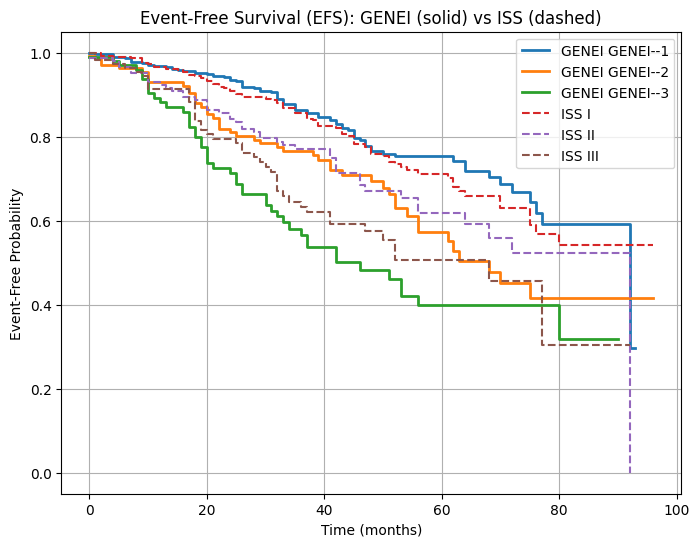

In [86]:
df = pd.read_csv(FILE_NAME)

# Fix type issues
df = df.dropna(subset=['ISS Staging'])
df[COLUMN_NAME] = df[COLUMN_NAME].astype(str)

kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

for g in sorted(df[COLUMN_NAME].unique()):
    sub = df[df[COLUMN_NAME] == g]
    kmf.fit(sub['OS_time'], sub['OS_event'], label=f"GENEI {g}")
    kmf.plot(ci_show=False, linestyle='-', lw=2)

for s in sorted(df['ISS Staging'].unique()):
    sub = df[df['ISS Staging'] == s]
    kmf.fit(sub['OS_time'], sub['OS_event'], label=f"ISS {s}")
    kmf.plot(ci_show=False, linestyle='--', lw=1.5)

plt.title("Overall Survival (OS): GENEI (solid) vs ISS (dashed)")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


# === OVERLAYED EFS ===
plt.figure(figsize=(8,6))

# Plot GENEI (solid)
for g in sorted(df[COLUMN_NAME].unique()):
    sub = df[df[COLUMN_NAME] == g]
    kmf.fit(sub['EFS_time'], sub['EFS_event'], label=f"GENEI {g}")
    kmf.plot(ci_show=False, linestyle='-', lw=2)

# Plot ISS (dashed)
for s in sorted(df['ISS Staging'].unique()):
    sub = df[df['ISS Staging'] == s]
    kmf.fit(sub['EFS_time'], sub['EFS_event'], label=f"ISS {s}")
    kmf.plot(ci_show=False, linestyle='--', lw=1.5)

plt.title("Event-Free Survival (EFS): GENEI (solid) vs ISS (dashed)")
plt.xlabel("Time (months)")
plt.ylabel("Event-Free Probability")
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['ISS Staging', COLUMN_NAME], drop_first=True)

# Fit Cox model for OS
cph = CoxPHFitter()
cph.fit(df_encoded, duration_col='OS_time', event_col='OS_event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 558 total observations, 386 right-censored observations>
             duration col = 'OS_time'
                event col = 'OS_event'
      baseline estimation = breslow
   number of observations = 558
number of events observed = 172
   partial log-likelihood = -770.51
         time fit was run = 2025-11-12 11:36:08 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
EFS_time            -0.10      0.91      0.01           -0.11           -0.08                0.90                0.92
EFS_event           -1.30      0.27      0.22           -1.73           -0.87                0.18                0.42
EPAS1               -0.05      0.95      0.07           -0.19            0.08                0.83                1.09
ERC2                -0.04      0.96      0.05           -0.14            0.05                0.87                1.05
PRC1                 0.18      1.20      0.08            0.03            0.33                1.03                1.40
CSGALNACT1           0.12      1.12      0.08           -0.04            0.27                0.96                1.32
CCND1               -0.00      1.00      0.03           -0.06            0.05                0.94                1.06
Age                  0.03      1.03      0.01            0.01            0.05                1.01                1.05
Albumin             -0.24      0.79      0.16           -0.55            0.07                0.57                1.08
B2m                 -0.01      0.99      0.01           -0.04            0.02                0.97                1.02
Hemoglobin           0.25      1.29      0.06            0.14            0.36                1.15                1.44
Cyto                -1.09      0.34      0.45           -1.97           -0.21                0.14                0.81
Patient_ID          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
risk_score           0.07      1.07      0.12           -0.18            0.31                0.84                1.36
ISS Staging_II       0.26      1.30      0.22           -0.17            0.70                0.84                2.01
ISS Staging_III      0.60      1.83      0.28            0.06            1.14                1.06                3.14
risk_group_GENEI--2  0.90      2.46      0.37            0.17            1.63                1.18                5.11
risk_group_GENEI--3  1.79      6.00      0.59            0.64            2.94                1.90               18.94

                     cmp to      z      p  -log2(p)
covariate                                          
EFS_time               0.00 -16.34 <0.005    197.04
EFS_event              0.00  -5.90 <0.005     28.07
EPAS1                  0.00  -0.76   0.45      1.16
ERC2                   0.00  -0.89   0.37      1.43
PRC1                   0.00   2.35   0.02      5.73
CSGALNACT1             0.00   1.46   0.15      2.78
CCND1                  0.00  -0.06   0.95      0.07
Age                    0.00   3.29 <0.005      9.96
Albumin                0.00  -1.51   0.13      2.92
B2m                    0.00  -0.47   0.64      0.65
Hemoglobin             0.00   4.31 <0.005     15.88
Cyto                   0.00  -2.43   0.01      6.06
Patient_ID             0.00  -4.36 <0.005     16.25
risk_score             0.00   0.54   0.59      0.76
ISS Staging_II         0.00   1.18   0.24      2.08
ISS Staging_III        0.00   2.19   0.03      5.12
risk_group_GENEI--2    0.00   2.40   0.02      5.95
risk_group_GENEI--3    0.00   3.06 <0.005      8.80
---
Concordance = 0.94
Partial AIC = 1577.02
log-likelihood ratio test = 496.15 on 18 df
-log2(p) of ll-ratio test = 309.52

In [88]:

# Load data
df = pd.read_csv(FILE_NAME)
df = df.dropna(subset=['ISS Staging'])
df['ISS Staging'] = df['ISS Staging'].astype(str)
df[COLUMN_NAME] = df[COLUMN_NAME].astype(str)

kmf = KaplanMeierFitter()

# --- Median survival for GENEI ---
print("\nGENEI groups:")
for g in sorted(df[COLUMN_NAME].unique()):
    sub = df[df[COLUMN_NAME] == g]
    kmf.fit(sub['OS_time'], sub['OS_event'], label=g, alpha=0.10)  # 90% CI
    median_ = kmf.median_survival_time_
    ci = kmf.confidence_interval_survival_function_.iloc[:, 0].quantile([0.05, 0.95])
    print(f"{g}: median={median_:.2f} months (approx 90% CI: {ci.iloc[0]:.1f}–{ci.iloc[1]:.1f})")

# --- Median survival for ISS ---
print("\nISS Stages:")
for s in sorted(df['ISS Staging'].unique()):
    sub = df[df['ISS Staging'] == s]
    kmf.fit(sub['OS_time'], sub['OS_event'], label=s, alpha=0.10)
    median_ = kmf.median_survival_time_
    ci = kmf.confidence_interval_survival_function_.iloc[:, 0].quantile([0.05, 0.95])
    print(f"{s}: median={median_:.2f} months (approx 90% CI: {ci.iloc[0]:.1f}–{ci.iloc[1]:.1f})")



GENEI groups:
GENEI--1: median=inf months (approx 90% CI: 0.6–1.0)
GENEI--2: median=inf months (approx 90% CI: 0.4–0.9)
GENEI--3: median=41.00 months (approx 90% CI: 0.2–0.9)

ISS Stages:
I: median=inf months (approx 90% CI: 0.6–1.0)
II: median=inf months (approx 90% CI: 0.4–0.9)
III: median=55.00 months (approx 90% CI: 0.1–0.9)



[ISS Staging | OS_time]  log-rank: chi2=41.799, p=8.38e-10


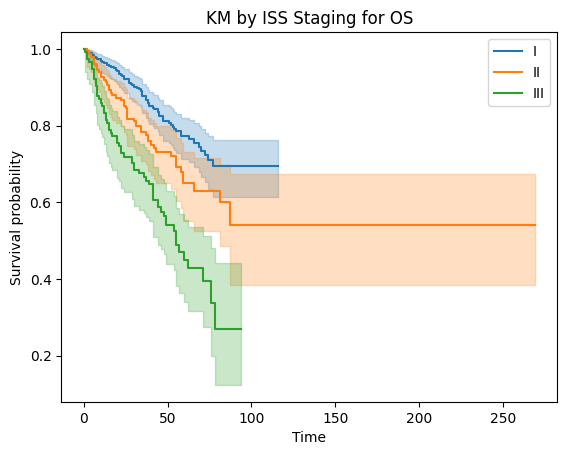


[ISS Staging | EFS_time]  log-rank: chi2=15.646, p=0.000401


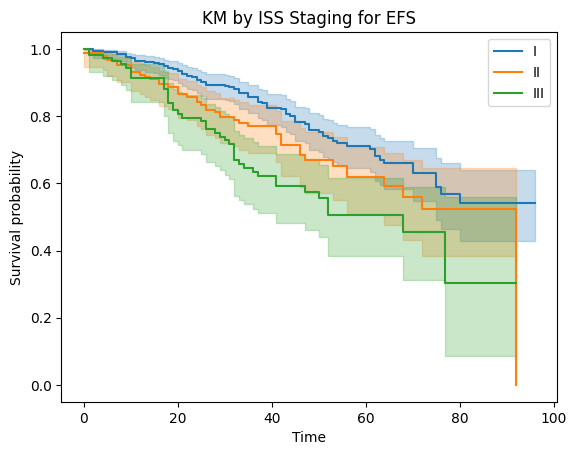


[risk_group | OS_time]  log-rank: chi2=77.477, p=1.5e-17


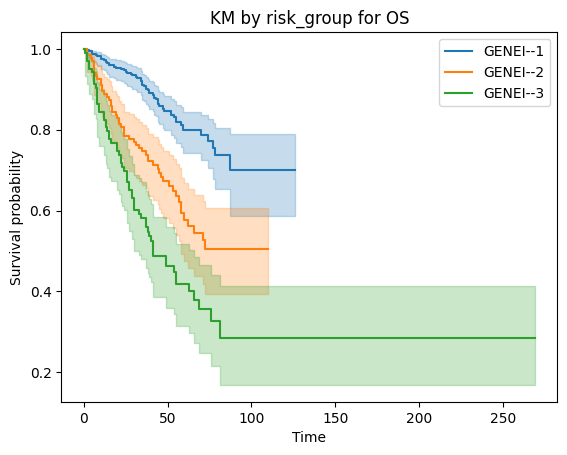


[risk_group | EFS_time]  log-rank: chi2=37.998, p=5.61e-09


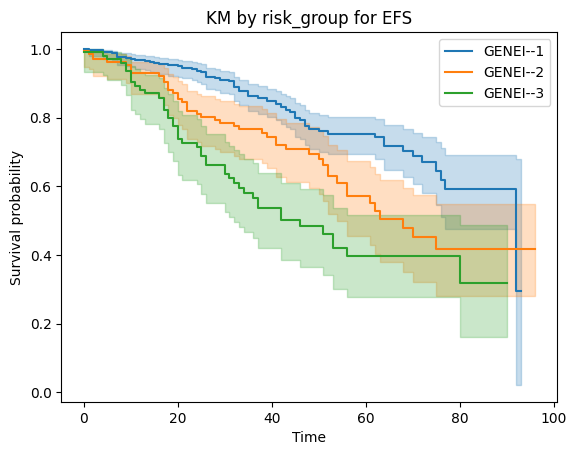

In [ ]:
def km_logrank(df, time_col, event_col, group_col, title_suffix=""):
    # Log-rank test
    res = multivariate_logrank_test(
        event_durations=df[time_col],
        groups=df[group_col],
        event_observed=df[event_col]
    )
    print(f"\n[{group_col} | {time_col}]  log-rank: chi2={res.test_statistic:.3f}, p={res.p_value:.3g}")

    # Plot KM curves
    kmf = KaplanMeierFitter()
    plt.figure()
    for g, dfg in df.groupby(group_col):
        kmf.fit(durations=dfg[time_col], event_observed=dfg[event_col], label=str(g))
        kmf.plot(ci_show=True)
    plt.title(f"KM by {group_col} for {title_suffix or time_col}")
    plt.xlabel("Time")
    plt.ylabel("Survival probability")
    plt.show()

# Run for both models and both endpoints
for grp in ["ISS Staging", COLUMN_NAME]:
    km_logrank(df, "OS_time",  "OS_event",  grp, title_suffix="OS")
    km_logrank(df, "EFS_time", "EFS_event", grp, title_suffix="EFS")


In [90]:
def cox_fit_info(df, time_col, event_col, group_col):
    # One-hot encode the group (drop first to avoid collinearity)
    X = pd.get_dummies(df[[group_col]], drop_first=True)
    X[time_col] = df[time_col].values
    X[event_col] = df[event_col].values

    cph = CoxPHFitter()
    cph.fit(X, duration_col=time_col, event_col=event_col)
    ll = cph.log_likelihood_
    try:
        aic = cph.AIC_partial_
    except AttributeError:
        # Fallback if lifelines version doesn't expose AIC; compute AIC = -2*LL + 2*k
        k = X.shape[1] - 2  # number of coefficients (dummies); minus time+event
        aic = -2*ll + 2*k

    print(f"[{group_col} | {time_col}]  logLik={ll:.3f}, AIC={aic:.3f}")
    # Optional: hazard ratios per category vs reference
    print(cph.summary[["exp(coef)", "p"]])
    return cph

cox_models = {}
for grp in ["ISS Staging", COLUMN_NAME]:
    cox_models[(grp, "OS")]  = cox_fit_info(df, "OS_time",  "OS_event",  grp)
    cox_models[(grp, "EFS")] = cox_fit_info(df, "EFS_time", "EFS_event", grp)


[ISS Staging | OS_time]  logLik=-1000.425, AIC=2004.850
                 exp(coef)             p
covariate                               
ISS Staging_II    1.608961  1.280636e-02
ISS Staging_III   3.053758  5.420159e-10
[ISS Staging | EFS_time]  logLik=-950.527, AIC=1905.055
                 exp(coef)         p
covariate                           
ISS Staging_II    1.412676  0.063451
ISS Staging_III   2.088875  0.000112
[risk_group | OS_time]  logLik=-984.819, AIC=1973.638
                     exp(coef)             p
covariate                                   
risk_group_GENEI--2   2.495213  1.518185e-06
risk_group_GENEI--3   4.481644  3.457514e-16
[risk_group | EFS_time]  logLik=-941.180, AIC=1886.361
                     exp(coef)             p
covariate                                   
risk_group_GENEI--2   1.792607  1.788133e-03
risk_group_GENEI--3   3.016797  4.700642e-09


In [91]:

def cindex_from_cox(df, time_col, event_col, cph, group_col):
    X = pd.get_dummies(df[[group_col]], drop_first=True)
    risk = cph.predict_partial_hazard(X).values
    c = concordance_index(df[time_col].values, -risk, df[event_col].values)
    #lifelines' concordance_index expects larger predicted values = longer survival, hence we pass -risk.
    return c

for grp in ["ISS Staging", COLUMN_NAME]:
    c_os  = cindex_from_cox(df, "OS_time",  "OS_event",  cox_models[(grp, "OS")],  grp)
    c_efs = cindex_from_cox(df, "EFS_time", "EFS_event", cox_models[(grp, "EFS")], grp)
    print(f"[{grp}]  C-index OS={c_os:.3f} | EFS={c_efs:.3f}")

[ISS Staging]  C-index OS=0.622 | EFS=0.591
[risk_group]  C-index OS=0.674 | EFS=0.628


In [92]:
def cox_predicted_risk_at_T(df, time_col, event_col, group_col, T):
    # one-hot
    X = pd.get_dummies(df[[group_col]], drop_first=True)
    dat = pd.concat([X, df[[time_col, event_col]]], axis=1)

    cph = CoxPHFitter()
    cph.fit(dat, duration_col=time_col, event_col=event_col)

    # baseline survival and individual survival at T
    surv_at_T = cph.predict_survival_function(X, times=[T]).T.iloc[:, 0].values
    risk_at_T = 1.0 - surv_at_T  # cumulative incidence by T
    return risk_at_T

def nri_idi_at_T(df, time_col, event_col, T, riskA, riskB):
    # Observed status by T (1 if event occurred by T)
    status_T = ((df[event_col] == 1) & (df[time_col] <= T)).astype(int).values
    # Non-events by T: either censored after T or event after T (treated as 0 here)
    # (Note: this simplification ignores censoring bias)

    # Continuous NRI components
    events_idx = status_T == 1
    nonevents_idx = status_T == 0

    # For events: up = riskB > riskA; down = riskB < riskA
    p_up_events = np.mean((riskB[events_idx] > riskA[events_idx])) if events_idx.any() else np.nan
    p_down_events = np.mean((riskB[events_idx] < riskA[events_idx])) if events_idx.any() else np.nan

    # For non-events: up = worse (risk increases), down = better (risk decreases)
    p_up_nonevents = np.mean((riskB[nonevents_idx] > riskA[nonevents_idx])) if nonevents_idx.any() else np.nan
    p_down_nonevents = np.mean((riskB[nonevents_idx] < riskA[nonevents_idx])) if nonevents_idx.any() else np.nan

    nri_events = (p_up_events - p_down_events) if events_idx.any() else np.nan
    nri_nonevents = (p_down_nonevents - p_up_nonevents) if nonevents_idx.any() else np.nan
    nri_total = np.nansum([nri_events, nri_nonevents])

    # IDI = (mean risk among events increases) + (mean risk among non-events decreases)
    mean_diff_events = (np.mean(riskB[events_idx]) - np.mean(riskA[events_idx])) if events_idx.any() else np.nan
    mean_diff_nonevents = (np.mean(riskA[nonevents_idx]) - np.mean(riskB[nonevents_idx])) if nonevents_idx.any() else np.nan
    idi = np.nansum([mean_diff_events, mean_diff_nonevents])

    out = {
        "p_up_events": p_up_events, "p_down_events": p_down_events,
        "p_up_nonevents": p_up_nonevents, "p_down_nonevents": p_down_nonevents,
        "NRI_events": nri_events, "NRI_nonevents": nri_nonevents, "NRI_total": nri_total,
        "IDI": idi
    }
    return out

# Choose a time horizon T (e.g., 24 months); adjust to your scale
T = 24.0

# Predicted risks at T for each model
riskA_OS  = cox_predicted_risk_at_T(df, "OS_time",  "OS_event",  "ISS Staging", T)
riskB_OS  = cox_predicted_risk_at_T(df, "OS_time",  "OS_event",  COLUMN_NAME,  T)
riskA_EFS = cox_predicted_risk_at_T(df, "EFS_time", "EFS_event", "ISS Staging", T)
riskB_EFS = cox_predicted_risk_at_T(df, "EFS_time", "EFS_event", COLUMN_NAME,  T)

print("\nNRI/IDI at T for OS (Tree_group vs ISS Staging):")
print(nri_idi_at_T(df, "OS_time",  "OS_event",  T, riskA_OS,  riskB_OS))

print("\nNRI/IDI at T for EFS (Tree_group vs ISS Staging):")
print(nri_idi_at_T(df, "EFS_time", "EFS_event", T, riskA_EFS, riskB_EFS))



NRI/IDI at T for OS (Tree_group vs ISS Staging):
{'p_up_events': np.float64(0.6623376623376623), 'p_down_events': np.float64(0.33766233766233766), 'p_up_nonevents': np.float64(0.32432432432432434), 'p_down_nonevents': np.float64(0.6756756756756757), 'NRI_events': np.float64(0.3246753246753247), 'NRI_nonevents': np.float64(0.3513513513513513), 'NRI_total': np.float64(0.676026676026676), 'IDI': np.float64(0.02968694246262374)}

NRI/IDI at T for EFS (Tree_group vs ISS Staging):
{'p_up_events': np.float64(0.6323529411764706), 'p_down_events': np.float64(0.36764705882352944), 'p_up_nonevents': np.float64(0.3346938775510204), 'p_down_nonevents': np.float64(0.6653061224489796), 'NRI_events': np.float64(0.2647058823529411), 'NRI_nonevents': np.float64(0.33061224489795915), 'NRI_total': np.float64(0.5953181272509003), 'IDI': np.float64(0.027093212325964816)}
